In [66]:
import tensorflow_hub as hub
import librosa
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import time
import shutil

In [67]:
# Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [68]:
# Function to extract embeddings
def extract_features_yamnet(directory):
    features, labels = [], []
    for label, speaker in enumerate(os.listdir(directory)):
        speaker_path = os.path.join(directory, speaker)
        if os.path.isdir(speaker_path):
            for file in os.listdir(speaker_path):
                file_path = os.path.join(speaker_path, file)
                try:
                    # Load audio
                    audio, sr = librosa.load(file_path, sr=16000)
                    # Ensure consistent audio length (1 second)
                    desired_length = sr  # 16000 samples for 1 second
                    audio = librosa.util.fix_length(audio, size=desired_length)
                    # Extract embeddings using YAMNet
                    _, embeddings, _ = yamnet_model(audio)
                    features.append(np.mean(embeddings.numpy(), axis=0))  # Average over time
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels)

In [69]:
# Function to train model
def train_model(X_train, y_train, X_val, y_val, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping]
    )

    return model, history

In [70]:
# Paths to train and validation directories
train_dir = "/content/drive/MyDrive/smart_vote/voice_data/train"
val_dir = "/content/drive/MyDrive/smart_vote/voice_data/val"

In [71]:
# Extract features for initial training
X_train, y_train = extract_features_yamnet(train_dir)
X_val, y_val = extract_features_yamnet(val_dir)

In [72]:
# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)


In [73]:
# Train the model
model, history = train_model(X_train, y_train, X_val, y_val, num_classes)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2668 - loss: 2.3661 - val_accuracy: 0.4375 - val_loss: 1.7438
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3188 - loss: 2.2354 - val_accuracy: 0.3750 - val_loss: 1.7078
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4211 - loss: 2.0310 - val_accuracy: 0.3750 - val_loss: 1.6759
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3443 - loss: 1.8452 - val_accuracy: 0.5000 - val_loss: 1.6556
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4779 - loss: 1.7948 - val_accuracy: 0.5000 - val_loss: 1.6421
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4576 - loss: 1.7835 - val_accuracy: 0.5000 - val_loss: 1.6169
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5192 - loss: 1.6716 - val_accuracy: 0.6250 - val_loss: 1.5814
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5699 - loss: 1.4478 - val_accuracy: 0.5625 - val_loss:

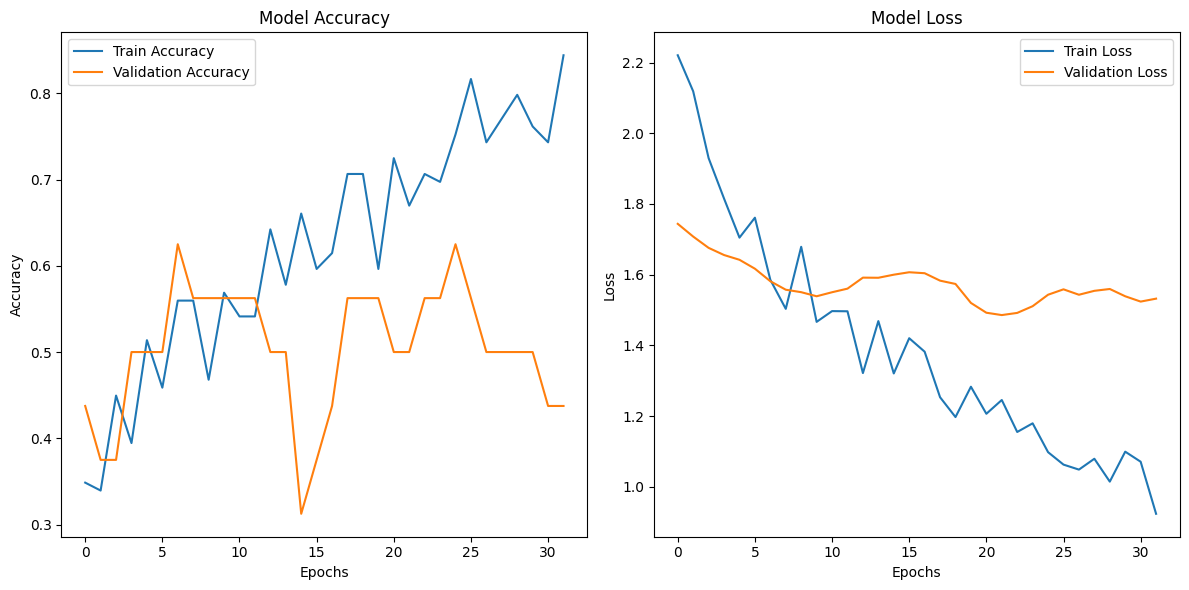

In [79]:
import matplotlib.pyplot as plt
# Function to plot accuracy and loss graphs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# After training your model, call the plot function with the history object
plot_training_history(history)


In [74]:
# Save the initial model
model.save('/content/drive/MyDrive/smart_vote/voice_model.h5')

In [75]:
def auto_train(new_data_dir, model_save_path, interval=2, max_iterations=2):
    iteration = 0
    while iteration < max_iterations:
        print(f"Iteration {iteration + 1} of {max_iterations}...")
        print("Checking for new data...")

        # Check if new data exists in the new_data_dir
        new_train_dir = os.path.join(new_data_dir, 'train')
        new_val_dir = os.path.join(new_data_dir, 'val')

        # If new data is available, retrain the model
        if os.path.exists(new_train_dir) and os.path.exists(new_val_dir):
            print("New data detected, retraining the model...")

            # Extract features from the new data
            X_train_new, y_train_new = extract_features_yamnet(new_train_dir)
            X_val_new, y_val_new = extract_features_yamnet(new_val_dir)

            # One-hot encode the new labels
            y_train_new = to_categorical(y_train_new, num_classes)
            y_val_new = to_categorical(y_val_new, num_classes)

            # Retrain the model with new data
            model, history = train_model(X_train_new, y_train_new, X_val_new, y_val_new, num_classes)

            # Save the retrained model
            model.save(model_save_path)
            print(f"Model saved to {model_save_path}")
        else:
            print("No new data found.")

        # Wait for the specified interval before checking again
        print(f"Waiting for {interval} seconds before checking for new data.")
        time.sleep(interval)

        iteration += 1
    print("Max iterations reached, stopping auto-training.")


In [76]:
# Run auto-training every 60 seconds, change interval as needed
auto_train("/content/drive/MyDrive/smart_vote/voice_data", '/content/drive/MyDrive/smart_vote/voice_model.h5', interval=60)

Iteration 1 of 2...
Checking for new data...
New data detected, retraining the model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.3516 - loss: 2.3090 - val_accuracy: 0.4375 - val_loss: 1.7472
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2768 - loss: 2.3569 - val_accuracy: 0.5000 - val_loss: 1.7016
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4887 - loss: 1.9737 - val_accuracy: 0.3750 - val_loss: 1.6640
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4695 - loss: 1.8460 - val_accuracy: 0.4375 - val_loss: 1.6353
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5093 - loss: 1.6074 - val_accuracy: 0.4375 - val_loss: 1.6166
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4705 - loss: 1.6249 - val_accuracy: 0.4375 - val_loss: 1.6033
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4087 - loss: 1.6984 - val_accuracy: 0.3125 - val_loss: 1.5971
Epoch 8/100
7/7 ━━━━━━━━━━━━━━

Model saved to /content/drive/MyDrive/smart_vote/voice_model.h5
Waiting for 60 seconds before checking for new data.
Iteration 2 of 2...
Checking for new data...
New data detected, retraining the model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2940 - loss: 2.6393 - val_accuracy: 0.3125 - val_loss: 1.7696
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3417 - loss: 2.1762 - val_accuracy: 0.5000 - val_loss: 1.7177
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3897 - loss: 2.3199 - val_accuracy: 0.3125 - val_loss: 1.7100
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3438 - loss: 2.1275 - val_accuracy: 0.2500 - val_loss: 1.7041
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4659 - loss: 1.7208 - val_accuracy: 0.3125 - val_loss: 1.6737
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4411 - loss: 1.8753 - val_accuracy: 0.4375 - val_loss: 1.6412
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

Model saved to /content/drive/MyDrive/smart_vote/voice_model.h5
Waiting for 60 seconds before checking for new data.
Max iterations reached, stopping auto-training.


In [ ]:
#testing

In [77]:
import librosa
import numpy as np

# Function to preprocess and extract features from a new audio file
def extract_features_from_audio(file_path):
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=16000)  # Match the sample rate used during training

        # Ensure consistent audio length (1 second)
        desired_length = sr  # 16000 samples for 1 second
        audio = librosa.util.fix_length(audio, size=desired_length)

        # Extract embeddings using YAMNet
        _, embeddings, _ = yamnet_model(audio)

        # Average the embeddings over time (just like during training)
        feature = np.mean(embeddings.numpy(), axis=0)

        return feature
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [78]:
# Path to the new audio file you want to test
test_audio_file = '/content/drive/MyDrive/smart_vote/voice_data/test/ElevenLabs_2024-11-22T14_46_57_Daniel_pre_s50_sb75_se0_b_m2.mp3'  # Replace with your actual file path

# Extract features from the new audio file
test_features = extract_features_from_audio(test_audio_file)

if test_features is not None:
    # Reshape the features to match the model's input shape (add batch dimension)
    test_features = test_features.reshape(1, -1)

    # Make a prediction using the trained model
    prediction = model.predict(test_features)

    # Get the class with the highest probability
    predicted_class_index = np.argmax(prediction, axis=1)

    # If you used one-hot encoding during training, reverse it using your class labels
    class_labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your actual class labels

    predicted_label = class_labels[predicted_class_index[0]]

    # Print the predicted class label
    print(f"Predicted class: {predicted_label}")
else:
    print("Failed to extract features from the audio file.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted class: Class 3
